<a href="https://colab.research.google.com/github/pseudope/Parrot_5th_Level1/blob/main/MNIST_Week2_Day2_9_(image_augmentation).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#!/usr/bin/env python3
!pip install einops
#!pip install tensorflow --user

import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import os

from tensorflow.data import Dataset
from tensorflow.keras.models import Model
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.layers import Input, Dense, Conv2D, Dropout, Flatten, Activation, MaxPooling2D, BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from einops import rearrange
from sklearn.model_selection import train_test_split

In [2]:
(X_train, y_train), (X_test, y_test) = tf.keras.datasets.mnist.load_data()

print("X_train shape: {}".format(X_train.shape))
print("X_test shape: {}".format(X_test.shape))

11501568/11490434 [==============================] - 0s 0us/step
X_train shape: (60000, 28, 28)
X_test shape: (10000, 28, 28)


In [3]:
pwd

'/content'

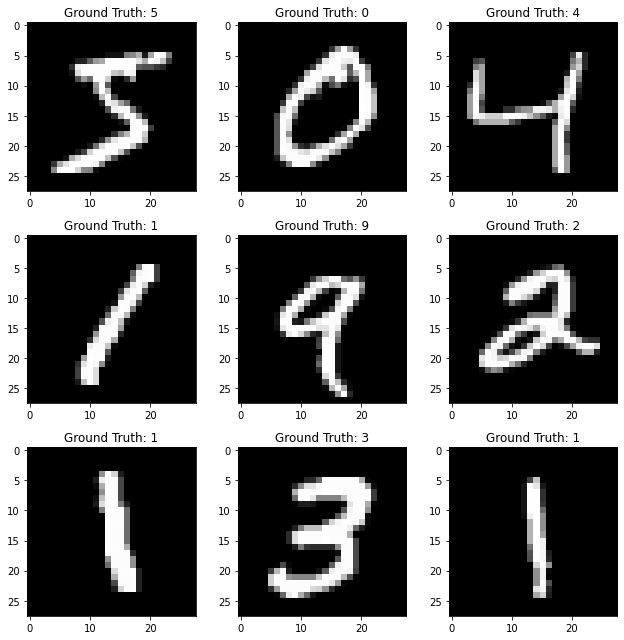

In [4]:
fig = plt.figure(figsize=(9, 9))

for i in range(9):
    plt.subplot(3, 3, 1 + i)
    plt.tight_layout()
    plt.imshow(X_train[i], cmap="gray", interpolation="none")
    target = y_train[i]
    plt.title("Ground Truth: {}".format(int(target)))

plt.show()

In [5]:
target_size = 10   # 0 ~ 9, 총 9개

### 주의: 흑백 데이터여도 channel 차원을 살려주어야 정상적으로 작동합니다
X_train = rearrange(X_train, "b h w -> b h w 1")
X_test = rearrange(X_test, "b h w -> b h w 1")

X_train = X_train.astype("float32") / (2 ** 8 - 1)   # 255로 scaling
X_test = X_test.astype("float32") / (2 ** 8 - 1)     # 255로 scaling

y_train = to_categorical(y_train, target_size)       # 타겟을 정수로 변환
y_test = to_categorical(y_test, target_size)         # 타겟을 정수로 변환

In [6]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2)

In [7]:
datagen = ImageDataGenerator(
        rotation_range=10,  
        zoom_range = 0.10,  
        width_shift_range=0.1, 
        height_shift_range=0.1)
datagen.fit(X_train)


In [8]:
print(X_train.shape)
print(X_val.shape)
print(X_test.shape)
print(y_train.shape)
print(y_val.shape)
print(y_test.shape)

(48000, 28, 28, 1)
(12000, 28, 28, 1)
(10000, 28, 28, 1)
(48000, 10)
(12000, 10)
(10000, 10)


Changes Made:
*   data augmentation added

0.9956 (1) -> 0.9951 (2)














In [9]:
inputs = Input(shape=(28, 28, 1))

X = Conv2D(filters=64, kernel_size=(3, 3), padding="Same", kernel_initializer='he_uniform')(inputs)
X = BatchNormalization()(X)
X = Activation("swish")(X)
X = Conv2D(filters=64, kernel_size=(3, 3), padding="Same", kernel_initializer='he_uniform')(X)
X = Activation("swish")(X)
X = MaxPooling2D(pool_size=(2, 2), strides=(2, 2))(X)

X = Conv2D(filters=32, kernel_size=(3, 3), padding="Same", kernel_initializer='he_uniform')(X)
X = BatchNormalization()(X)
X = Activation("swish")(X)
X = Conv2D(filters=32, kernel_size=(3, 3), padding="Same", kernel_initializer='he_uniform')(X)
X = Activation("swish")(X)
X = MaxPooling2D(pool_size=(2, 2), strides=(2, 2))(X)

X = Flatten()(X)
#X = Dense(256, activation="swish")(X)
#X = BatchNormalization()(X)
#X = Dropout(0.5)(X)
X = Dense(128, activation="swish")(X)
X = BatchNormalization()(X)
X = Dropout(0.4)(X)
X = Dense(64, activation="swish")(X)
X = BatchNormalization()(X)
X = Dropout(0.2)(X)
outputs = Dense(10, activation="softmax")(X)

model = Model(inputs=inputs, outputs=outputs)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 conv2d (Conv2D)             (None, 28, 28, 64)        640       
                                                                 
 batch_normalization (BatchN  (None, 28, 28, 64)       256       
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 28, 28, 64)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 28, 28, 64)        36928     
                                                                 
 activation_1 (Activation)   (None, 28, 28, 64)        0         
                                                             

In [10]:
def scheduler(epoch, lr):
  if epoch < 8:
    return lr
  else:
    return lr * tf.math.exp(-0.1)

checkpoint_filepath = '/tmp/checkpoint'


callback = [
            tf.keras.callbacks.LearningRateScheduler(scheduler),
            tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=7),
            tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_filepath,
                                               monitor="val_loss", 
                                               mode="min",
                                               save_best_only=True)
]

model.compile(optimizer='adam', loss="categorical_crossentropy", metrics=["accuracy"])
history = model.fit(x=datagen.flow(X_train, y_train), batch_size=256, epochs=20, callbacks = callback, validation_data=(X_val, y_val), verbose=1)
model.load_weights(checkpoint_filepath)

Epoch 1/20
  79/1500 [>.............................] - ETA: 5:15 - loss: 1.3059 - accuracy: 0.5850

KeyboardInterrupt: ignored

In [ ]:
model.evaluate(X_test, y_test, batch_size=256)

In [ ]:
def acc_loss_plot(hist):
    
    fit, loss_ax = plt.subplots()
    acc_ax = loss_ax.twinx()
    
    loss_ax.plot(hist.history["loss"], "y", label="train_loss")
    loss_ax.plot(hist.history["val_loss"], "r", label="val_loss")
    loss_ax.set_xlabel("Epoch")
    loss_ax.set_ylabel("Loss")
    loss_ax.legend(loc = "upper left")
    
    acc_ax.plot(hist.history["accuracy"], "b", label="train_acc")
    acc_ax.plot(hist.history["val_accuracy"], "g", label="val_acc")
    acc_ax.set_ylabel("Accuracy")
    acc_ax.legend(loc = "upper right")
    
    plt.show()

In [ ]:
acc_loss_plot(history)